####Enable inline to print graphs within Notebook

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


####Import packages

In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #seaborn is a very pretty graphing package
import nltk as nltk
import numpy as np
import networkx as nx
import csv as csv
import heapq
from pyper import R
from sklearn.feature_extraction.text import TfidfVectorizer 
import sklearn.cluster as sk
import pickle

r = R(use_pandas = True)

import nibabel as nib

In [3]:
poplist = ["THAT", "WHICH", "FROM", "SUCH", "ABOUT", 
           "LIKE", "WERE", "WITH", "THIS", "WHEN", "THAN", "EACH", "BETWEEN"
            'THEY', 'USING', 'WHETHER', 'ALSO', "HOWEVER", "RESULTS", "THESE",
           "BOTH", "USED", "ONLY", "THEY", "THEIR", "DURING", "WHILE"
          ]
wordlist = [ 'allowed', 'us', 'recent', 'studies', 'remains', 'into', 'previous', 'viewed',
            'more', 'during', '=', '[', ']', "'s", '%', 'across', 'all'
            'are', 'both', 'or', 'such', 'as', 'was', '<', 'an', 'that', 'suggest', 
            'results', 'with', 'et', 'al', 'were', 'found', 'can', 'our', 'participants', 'been',
            'be', 'it', 'is', ')', ';',  '(', 'may','we', 'have', 'has', 
            'the', 'in', 'of', 'a', 'and', 'for', ',', '.', 'these', '\'', 
            ':', 'by', 'does', 'on', 'but', 'each', 'trial', 'this', 'over', 'had', 'no', 
             'ms', 'experiments', 'how', 'towards', 'showed', 'shows', 'i',  
            'are', 'there', 'even', 'though', 'important', 'significantly',
            'study', 'rather', 'than', 'not', 'to', 'from', 'when', 'experiment',
            'revealed', 'abstracts', 'abstract', 'likely', 'all', 'findings', 'typically',
            'provide', '&',
           'they', 'per', 'presented', 'at', 'about', 'between', 'observers' ,'sup', 
            '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014']
for i in poplist:
    if i.lower() not in wordlist:
        wordlist.append(i.lower())  


In [24]:
####Read in all abstracts
allFiles = glob.glob("all_abstracts/*.txt")
df = pd.DataFrame()
list_ = []
for file_ in allFiles:
    infile = open(file_,'r')
    for line in infile:
        indict = eval(line)
        
        list_.append(indict)
        
df = pd.DataFrame(list_)
df['year'] = df['date'].apply(lambda x: pd.Series(x[0:4]))

#add abstracts in new column, now strings
df["abstract"] = df["abstact"].apply(lambda x: pd.Series(x[0].lower()) if len(x) > 0 else pd.Series(" "))
df.head()

#remove nonspikes
for year in set(df.date):
    if len(df[df.date == year]) < 400:
        df = df[df.date != year]
        
#clean up authors
#load dict 


## Drop duplicate entries
df = df.drop_duplicates('abstract')
#df = df.reset_index()
#df = df.drop('index',1)
df = df.reset_index()
df.head()

,index,abstact,authors,date,title,year,abstract
0,0,[ Purpose: Being able to see one's hand while ...,"[J. Saunders, D. Knill]",2001/12/01,Response to perturbations of visual feedback d...,2001,purpose: being able to see one's hand while r...
1,1,[ Despite the richness of research testing per...,[D. T. Levin],2001/12/01,Visual metacognitions underlying change blindn...,2001,despite the richness of research testing perf...
2,2,[ Purpose: To design a simple experimental str...,[Manfred MacKeben],2001/12/01,Enhancement of peripheral letter recognition b...,2001,purpose: to design a simple experimental stra...
3,3,[ The two aims of this study were (1) to asses...,"[P. Zaenen, J. Wagemans, R. Vogels]",2001/12/01,Learning to discriminate highly similar three-...,2001,the two aims of this study were (1) to assess...
4,4,[ The current study was designed to investigat...,"[Y. Takarae, D. T. Levin]",2001/12/01,Is the pen mightier than the pen-axe? Correct ...,2001,the current study was designed to investigate...


In [7]:
#create a new data frame DF2 with one author/ row
infoListFiles = glob.glob('all_abstracts/abstracts_*')

## Read in abstracts and convert to dataFrame 
infoList = []
for i,infile in enumerate(infoListFiles):
    tmp = [eval(item) for item in open(infile)]
    for j,item in enumerate(tmp):
        #print item
        abstract = item['abstact']        
        try:
            tmp[j]['abstact'] = abstract[0] #make abstract just a string not a string in a list, necessary for evaluate duplicates
        except IndexError:
            #print item['title'] + " has no abstract"
            tmp[j]['abstact'] = ''
            
    infoList.extend(tmp)
    
df2 = pd.DataFrame(infoList)
df2 = df2[df2.abstact != '']
df2 = df2.drop_duplicates('abstact')


        
        
## Separate authors
i = df2['authors'].map(len)
j = np.repeat(np.arange(len(df2)), list(i))
k = np.concatenate(list(map(np.arange, list(i))))

df2 = df2.iloc[j]

for col in ['authors']:
    df2[col] = list(map(lambda xs, i: xs[i], df2[col], k)) 

## Drop duplicate entries

df2 = df2.reset_index()
df2 = df2.drop('index',1)


df2.head()

#replace authors in df2
name_dict = pickle.load(open( "replacement_dictionary.p") )
df2["authors"].replace(name_dict, inplace=True)

df2['year'] = df2['date'].apply(lambda x: pd.Series(x[0:4]))
#remove nonspikes
for year in set(df2.date):
    if len(df2[df2.date == year]) < 400:
        df2 = df2[df2.date != year]
df2.head()
len(set(df2.authors))

13105

In [5]:
#Read in COCA and put it into a data frame
filegram = pd.read_csv("2gramcountsWords.csv", sep=',', header = None)
filegram[3] = filegram[0] + " " + filegram[1]

filegram.head()
filegram_list = filegram[3].tolist()

####Count total titles per date and plot

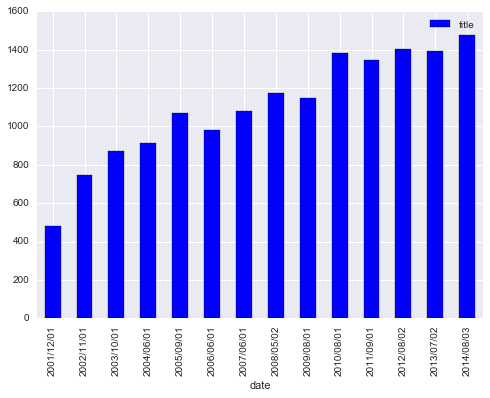

In [6]:
h = df.groupby('date')
g = h['title'].count().reset_index()
ax = g.plot(kind = "bar", x="date", y="title")

#### For text analysis, concatenate all tiles into one passage

#### Import text analysis packages 

In [6]:
import re #Regular expressions
from collections import Counter
import operator

# Authors

## Number of authors 

In [8]:
#Find the number of authors
author_list = []
auttest = []
adf = df["authors"]
for i in adf:
    for j in i:
        auttest.append(j)
for i in adf:
    for j in i:
        if j not in author_list:
            author_list.append(j)

print auttest[:10]
name_dict = pickle.load(open( "replacement_dictionary.p") )
for i in range(len(auttest)):
    if auttest[i] in name_dict.keys():
        auttest[i] = name_dict[auttest[i]]
    
#sort all the authors 
autcount = Counter(auttest)
autsort = sorted(autcount.items(), key=operator.itemgetter(0), reverse = True)
 

#number of unique authors (without grouping variations of a name together)
print "number of unique authors:", len(autsort)

['J. Saunders', 'D. Knill', 'D. T. Levin', 'Manfred MacKeben', 'P. Zaenen', 'J. Wagemans', 'R. Vogels', 'Y. Takarae', 'D. T. Levin', 'G. F. Woodman']
number of unique authors: 13105


## Average number of collaborators/paper/year

average number of collaborators/article: 2.82703366285


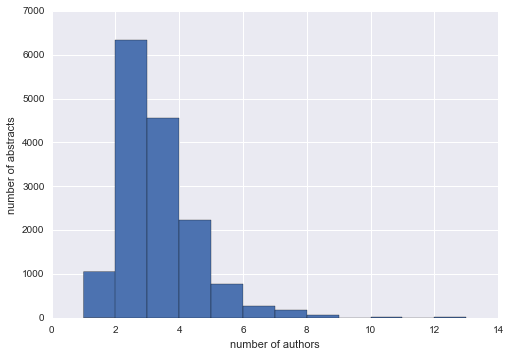

In [12]:
#avg number of collaborators/paper/year
cpy = []
col_hist = []
art_ct = 0

for i in range(2001, 2015):
    author_count = 0.0
    arts = df[df.year == str(i)]
    art_count = len(arts)
    for j in range(len(arts)):
        if len(df["authors"][j]) == 0:
            art_count = art_count - 1
        else:
            author_count = author_count + len(df["authors"][j])
            col_hist.append(len(df["authors"][j]))
    cpy.append(author_count/art_count)
    art_ct = art_ct + art_count*1.0

print "average number of collaborators/article:", sum(col_hist)/sum(art_ct)

plt.hist(col_hist, bins=range(min(col_hist), max(col_hist) + 2, 1
                                       ))
plt.xlabel("number of authors")
plt.ylabel("number of abstracts")

In [ ]:
#Visitor analysis. How many unique people came each year? Once someone came, what % of 
#possible years did they return again?

unique_authors = []
list_auts_freq = []
for day in range(2001, 2015):
    templist = df[df.year == str(day)]["authors"].tolist()
    #flatten it
    templist2 = []
    #replace names
    for i in templist:
        for k in i:
            if k in name_dict.keys():
                templist2.append(name_dict[k])
            else:
                templist2.append(k)
    #remove duplicates
    list_auts_freq.append([day, sorted(Counter(templist2).items(), 
                                       key=operator.itemgetter(1), reverse = True)])
    
    templist2 = list(set(templist2))
    unique_authors.append([day, templist2])
    
#graph it
u_aut_num = []
u_aut_yr = []
for i in unique_authors:
    u_aut_yr.append(int(i[0]))
    u_aut_num.append(len(i[1]))

plt.bar(u_aut_yr,u_aut_num)
plt.xlabel("year")
plt.ylabel("number of unique authors")


482
746
874
914
1070
984
1080
1176
1146
1384
1346
1403
1395
1477
[480, 746, 874, 910, 1065, 979, 1078, 1175, 1129, 1363, 1333, 1398, 1386, 1468]


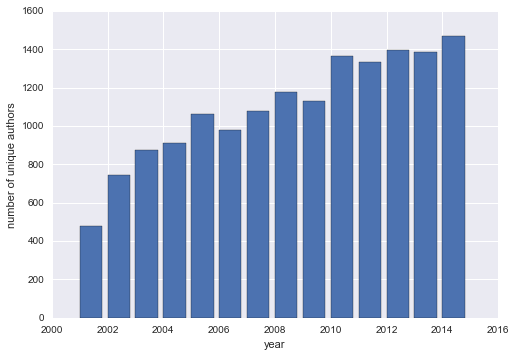

In [54]:
#number of unique first authors each year
u_first_authors = []
list_u_auts_freq = []
for day in range(2001, 2015):
    print len(df[df.year == str(day)])
    templist = df[df.year == str(day)]["authors"].tolist()
    #flatten it
    templist2 = []
    #replace names
    for i in templist:
        if i[0] in name_dict.keys():
            templist2.append(name_dict[i[0]])
        else:
            templist2.append(i[0])
    templist2 = list(set(templist2))
    u_first_authors.append([day, templist2])
    
#graph it
u_aut_num = []
u_aut_yr = []
for i in u_first_authors:
    u_aut_yr.append(int(i[0]))
    u_aut_num.append(len(i[1]))

plt.bar(u_aut_yr,u_aut_num)
plt.xlabel("year")
plt.ylabel("number of unique authors")
print u_aut_num

In [55]:
#look at first authors who publish twice a year 
dup = []
for day, autlist in u_first_authors:
    templist = []
    df_temp = df[df.year == str(day)]
    df_temp = df_temp.reset_index()
    for i in range(len(df_temp)):
        name = df_temp["authors"][i][0]
        if name in name_dict.keys():
            name = name_dict[name]
        if name in autlist:
            autlist.remove(name)
        else:
            templist.append(df_temp["authors"][i][0])
    dup.append([day, templist])    

In [64]:
df_rep = pd.DataFrame()
for day, autlist in dup: 
    df_temp = df[df.year == str(day)]
    df_temp = df_temp.reset_index()
    for i in range(len(df_temp)):
        name = df_temp["authors"][i][0]
        if name in name_dict.keys():
            name = name_dict[name]
        if name in autlist:
            df_rep = df_rep.append(df_temp[df_temp.index == i])

In [82]:
print dup[10
         ]

[2011, ['Martin Giese', 'Hakwan Lau', 'Jacqueline M. Fulvio', 'Rufin Vogels', 'Duje Tadin', "Shin'ya Nishida", 'Chia-Chien Wu', 'Matthew F. Peterson', 'Alexander A. Petrov', 'SooJin Park', 'Jonathan Zadra', 'Jacqueline M. Fulvio', 'Alexander A. Petrov']]


In [83]:
df_rep[df_rep.year == '2011'].head()

,level_0,index,abstact,authors,date,title,year,abstract
0,2201,2281,[Neural responses in many visual areas are usu...,[Rufin Vogels],2011/09/01,Symposium Summary,2011,Neural responses in many visual areas are usua...
82,2283,2363,"[To perceive a symmetry pattern, the observer ...","[Chia-Ching Wu, Chien-Chung Chen]",2011/09/01,The integration of color information in symmet...,2011,"To perceive a symmetry pattern, the observer h..."
425,2655,2806,"[Even in the absence of external stimulation, ...",[Hakwan Lau],2011/09/01,Symposium Summary,2011,"Even in the absence of external stimulation, t..."
459,2689,2840,[One recent study reported that when ongoing p...,"[Hakwan Lau, Dobromir Rahnev]",2011/09/01,The paradoxical negative relationship between ...,2011,One recent study reported that when ongoing pr...
481,2711,2862,"[In a world constantly in flux, we are faced w...","[Jacqueline M. Fulvio, Paul R. Schrater]",2011/09/01,Symposium Summary,2011,"In a world constantly in flux, we are faced wi..."


[359, 535, 609, 624, 693, 643, 678, 734, 723, 851, 807, 823, 820, 866]


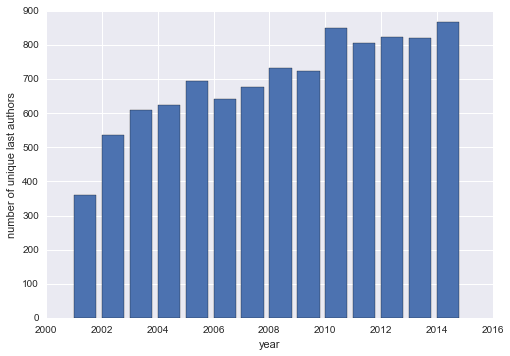

In [50]:
#number of unique last authors each year
u_last_authors = []
for day in range(2001, 2015):
    templist = df[df.year == str(day)]["authors"].tolist()
    #flatten it
    templist2 = []
    #replace names
    for i in templist:
        if i[len(i) - 1] in name_dict.keys():
            templist2.append(name_dict[i[len(i) - 1]])
        else:
            templist2.append(i[len(i) - 1])
    templist2 = list(set(templist2))
    u_last_authors.append([day, templist2])
    
#graph it
u_aut_num = []
u_aut_yr = []
for i in u_last_authors:
    u_aut_yr.append(int(i[0]))
    u_aut_num.append(len(i[1]))

plt.bar(u_aut_yr,u_aut_num)
plt.xlabel("year")
plt.ylabel("number of unique last authors")
print u_aut_num

(array([ 2722.,   589.,   269.,   168.,    96.,    85.,    87.,    64.,
           45.,    41.,    35.,    36.,    29.,    19.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 14 Patch objects>)

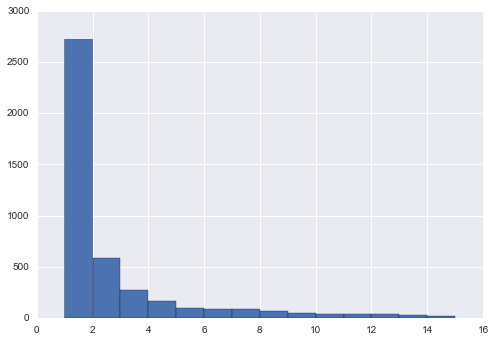

In [53]:
#see how many times each last author goes over all years

all_last_auts = list(set(sum([y for x, y in u_last_authors])))

last_aut_hist = []
for i in all_last_auts:
    ct = 0
    for day, autlist in u_last_authors:
        if i in autlist:
            ct = ct + 1
    last_aut_hist.append(ct)
plt.hist(last_aut_hist, bins=range(min(last_aut_hist), max(last_aut_hist) + 2, 1
                                       ))

In [12]:
#% of returns

#list of all unique authors

temp_aut_list = []
for i in unique_authors:
    temp_aut_list = temp_aut_list + i[1]
authors_allyears = list(set(temp_aut_list))

list_aut_years = []

for i in authors_allyears:
    templist = []
    for j in unique_authors:
        if i in j[1]:
            templist.append(j[0])
    list_aut_years.append([i, templist])


14


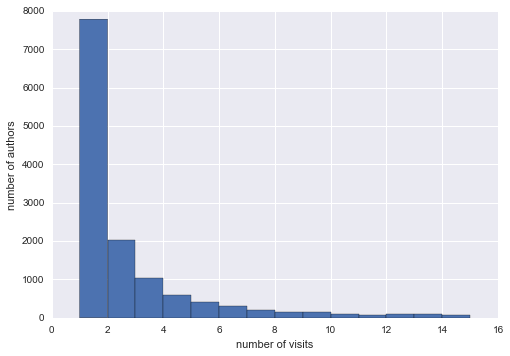

In [18]:
#Visits/per author 
hist_visit_per_aut = []
for i in list_aut_years:
    hist_visit_per_aut.append(len(i[1]))
    

plt.hist(hist_visit_per_aut, bins=range(min(hist_visit_per_aut), max(hist_visit_per_aut) + 2, 1
                                       ))
plt.xlabel("number of visits")
plt.ylabel("number of authors")
    

In [11]:
#2. Productivity of people. Who was most productive, increased the most/year, etc.
#%Reappearances
list_auts_change = []
for i in authors_allyears:
    yearlist = []
    freqlist = []
    for j in list_auts_freq:
        for k in j[1]:
            if i == k[0]:
                freqlist.append(k[1])
                yearlist.append(int(j[0]))
            
    list_auts_change.append([i, yearlist, freqlist])

['Allison B. Sekuler', 114]


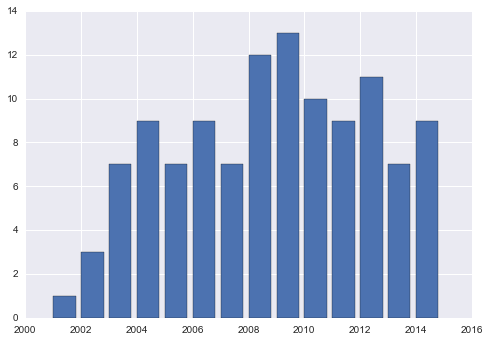

In [12]:
#most productive authors 

#(total # abstracts over all years)
aut_freq_hist = []

for i in list_auts_change:
    aut_freq_hist.append(sum(i[2]))
a = numpy.array(aut_freq_hist)
freq_index = heapq.nlargest(len(authors_allyears), range(len(a)), a.take)

#authors name + total abstracts
coll_list = []
for i in freq_index:
    coll_list.append([list_auts_change[i][0], aut_freq_hist[i]]) 

for i in list_auts_change:
    if i[0] == "Allison B. Sekuler":
         
        aut_yr = []
        for j in i[1]:
            aut_yr.append(int(j))
        plt.bar(aut_yr,i[2] )

print coll_list[0]

In [ ]:
#Are more productive authors also more collaborative? #collaborators/abstract 
ct = 0 
for i in coll_list:
    num_col = 0 
    #for j in range(len(df)):
    for j in df2[df2.authors == i[0]].title:
        num_col = num_col + len(df2[df2.title == j])
    i.append(num_col*1.0/i[1])
    ct = ct + 1
    if ct%1000 == 0:
        print ct


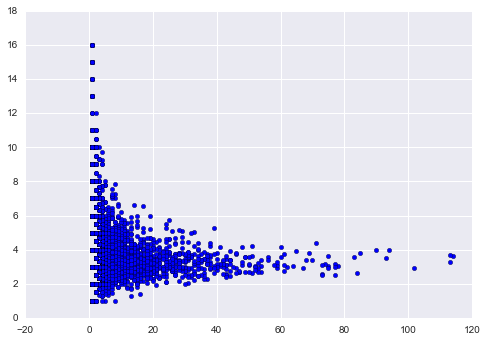

In [94]:
coll_x = []
coll_y = []

for i in coll_list:
    coll_x.append(i[1])
    coll_y.append(i[2])
plt.scatter(coll_x, coll_y)


In [143]:
#Are more productive people more likely to collaborate with new people each year? 
tt = 0
new_collabs = []
for i in [x for x, y,z in coll_list[:2000]]:
    colls_all = []
    for j in df2[df2.authors == i].title:
        colls_all.append([int(list(set(df2[df2.title == j].year.tolist()))[0]), df2[df2.title == j].authors.tolist()])
    #this gets list of [year, collabs]
    colls_edit = []
    colls_yr = sorted(map(int, list((set(df2[df2.authors == i].year.tolist())))))
    for j in colls_yr:
        templist = []
        for k in colls_all:
            if k[0] == j:
                templist = templist + k[1]
        colls_edit.append([j, set(templist) - set(i)])
    #get only new collaborators each year 
    for j in range(len(colls_yr)):
        for k in range(0, j):
            colls_edit[j][1] = colls_edit[j][1] - colls_edit[k][1]
    new_collabs.append(sum([len(y) for x, y in colls_edit])*1.0/len(colls_edit))
    tt = tt + 1
    if tt%200 == 0:
        print tt
    
    
                
#the min abstracts/author found is 5
 


200
400
600
800
1000
1200
1400
1600
1800
2000


[0, 120, 0, 10]

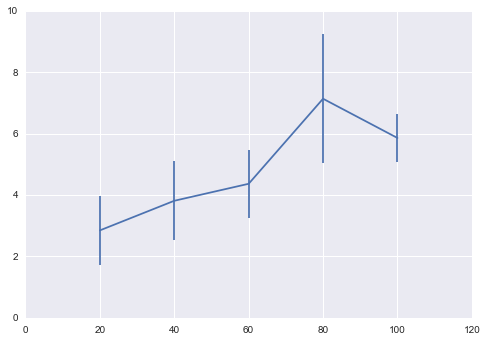

In [160]:
#plt.scatter(coll_x[:2000], new_collabs)

#only graph if submitted more than 20

colls_bin = []
for j in [40, 60, 80, 100, 120]:
    coll_ind =[]
    ct = 0
    for i in coll_x[:2000]:
        if i > j - 20 and i <= j:
            coll_ind.append(ct)
        ct = ct + 1
    colls_bin.append([sum([new_collabs[i] for i in coll_ind])*1.0/len(coll_ind), np.std(np.array([new_collabs[i] for i in coll_ind]))]) 

plt.errorbar([20, 40, 60, 80, 100], [x for x, y in colls_bin], yerr = [y for x, y in colls_bin])
        
plt.axis([0, 120, 0, 10])

In [148]:
print min(coll_x[:2000])

5


## Popular phrases across all titles

In [ ]:

#test: find popular phrases in ALL titles, no normalization
passage = df.title
passage2 = passage.str.cat(sep=" ")
passage2 = passage2.encode('unicode_escape').encode('ascii','ignore')

tok = nltk.word_tokenize(passage2.lower())
tok2 = list(nltk.bigrams(tok))
tok3 = list(nltk.trigrams(tok))

tok2test = []
tok3test = []

for i in tok2:
    count = 0
    for j in wordlist:
        if j in i:
            count = count + 1
    if count == 0:
        tok2test.append(i)

#test: sorts the words from ALL titles into order
passage = df.title.str.cat(sep=' ') #this specifies to treat titles as 'str' and the concat all cells with a space separating
words = re.findall(r'\w+', passage)
cap_words = [word.upper() for word in words]
word_counts = Counter(cap_words)

sorted_wc = sorted(word_counts.items(), key=operator.itemgetter(1), reverse = True)


# Break down titles and abstracts by year 
- finds the most frequent 1000 words for titles and abstracts
- finds the most frequent 2-word phrases for titles and abstracts
- filter: does not count words and phrases with words that appear in the wordlist above

In [7]:
#top 1000 words by year, and article number per year, using titles  
articles_year = {}
words_year = []
for i in range(2001, 2015):
    df_temp = df[df.year == str(i)]
    articles_year[i] = len(df_temp)
    passage_temp = df_temp.title.str.cat(sep=' ')
    words_temp = re.findall(r'\w+', passage_temp)
    cap_words_temp = [word.upper() for word in words_temp]
    word_counts_temp = Counter(cap_words_temp)
    sorted_wc_temp = sorted(word_counts_temp.items(), key=operator.itemgetter(1), reverse = True)
    ctt = 0
    ctt2 = 0
    temp20 = []
    
    while ctt2 < len(sorted_wc_temp) and ctt < 1000:
        if len(sorted_wc_temp[ctt2][0]) > 3:
            temp20.append([str(sorted_wc_temp[ctt2][0]), sorted_wc_temp[ctt2][1]])
            ctt = ctt + 1
        ctt2 = ctt2 + 1
    words_year.append( [i, temp20])

In [8]:
#ABSTRACT: top 1000 words by year
at_words_year = []
for i in range(2001, 2015):
    df_temp = df[df.year == str(i)]
    passage_temp = df_temp.abstract.str.cat(sep=' ')
    words_temp = re.findall(r'\w+', passage_temp)
    cap_words_temp = [word.upper() for word in words_temp]
    word_counts_temp = Counter(cap_words_temp)
    sorted_wc_temp = sorted(word_counts_temp.items(), key=operator.itemgetter(1), reverse = True)
    ctt = 0
    ctt2 = 0
    temp20 = []
    while ctt2 < len(sorted_wc_temp) and ctt < 1000:
        if len(sorted_wc_temp[ctt2][0]) > 3 and sorted_wc_temp[ctt2][0].lower() not in wordlist:
            temp20.append([str(sorted_wc_temp[ctt2][0]), sorted_wc_temp[ctt2][1]])
            ctt = ctt + 1
        ctt2 = ctt2 + 1
    at_words_year.append( [i, temp20])
 

In [9]:
#PHRASES, top 1000 phrases by year in abstracts 
phrases_year = []
for i in range(2001, 2015):
    df_temp = df[df.year == str(i)]
    passage_temp = df_temp.abstract.str.cat(sep=' ')
    passage_temp = passage_temp.decode('unicode_escape').encode('ascii','ignore')
    tok2 = nltk.word_tokenize(passage_temp.lower())
    tok2 = list(nltk.bigrams(tok2))
    tok2test = []
    for m in tok2:
        count = 0
        for j in wordlist:
            if j in m:
                count = count + 1
        if count == 0:
            tok2test.append(m)
        
    phrases_year.append([i, Counter(tok2test).most_common(1000)])


In [ ]:
#PHRASES, top 1000 phrases by year in titles
#can't run 1000 phrases in title or 1000 phrases in abstracts simultaneously!
'''
phrases_year = []
for i in range(2001, 2015):
    df_temp = df[df.year == str(i)]
    passage_temp = df_temp.title.str.cat(sep=" ")
    passage_temp = passage_temp.encode('unicode_escape').encode('ascii','ignore')
    tok2 = nltk.word_tokenize(passage_temp.lower())
    tok2 = list(nltk.bigrams(tok2))
    tok2test = []
    for m in tok2:
        count = 0
        for j in wordlist:
            if j in m:
                count = count + 1
        if count == 0:
            tok2test.append(m)
        
    phrases_year.append([i, Counter(tok2test).most_common(1000)])
'''

## Create dictionaries 
- lists all the words (and phrases) across all years 

In [10]:
#generates massive list of top 1000 words (top 1000 phrases) from each year
#duplicates removed 
'''
words_allyears = []
for i in words_year:
    for j in range(1000):
        if i[1][j][0] not in words_allyears:
            words_allyears.append(i[1][j][0])
'''
at_words_allyears = []
for i in at_words_year:
    for j in range(1000):
        if i[1][j][0] not in at_words_allyears:
            at_words_allyears.append(i[1][j][0])


phrases_allyears = []
for i in phrases_year:
    for j in range(1000):
        if i[1][j][0] not in phrases_allyears:
            phrases_allyears.append(i[1][j][0])
          

## Methods for finding normalized frequencies of words and frequencies from each year (for later)

In [11]:
#generates list of years and corresponding word count 

def word_change(word):
    ly = []
    for year in words_year:
        for i in range(1000): 
            if year[1][i][0] == word:
                ly.append([year[0], year[1][i][1]*1.00/articles_year[year[0]]])
    return ly 

def at_word_change(word):
    ly = []
    for year in at_words_year:
        for i in range(1000): 
            if year[1][i][0] == word:
                ly.append([year[0], year[1][i][1]*1.00/articles_year[year[0]]])
    return ly 
#a phrase is a list of tokens
def phrase_change(phrase):
    ly = []
    for year in phrases_year:
        for i in range(1000):
            if year[1][i][0] == phrase:
                ly.append([year[0], year[1][i][1]*1.00/articles_year[year[0]]])
    return ly


# Phrases and COCA
- finds phrases in COCA and phrases unique to VSS 
- uses 'human brain' as the cutoff above which phrases will not be considered
- creates a new list, union_list, that can be used in replacement of phrases_allyears

In [14]:
#compares phrases from abstracts with those in the 2gramcounts data frame
preset = []
for i in phrases_allyears:
    preset.append(i[0] + ' ' + i[1])

set_2grams = set(filegram_list)
set_VSS = set(preset)
#phrases (in token form) unique to VSS
set_diff = set_VSS - set_2grams


In [ ]:
#saves the unique to VSS phrases in csv 
with open('VSSphrases.csv', 'wb') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=' ',
                             quoting=csv.QUOTE_MINIMAL)
    for i in set_diff:
        spamwriter.writerow(i)    

In [15]:
#finds phrases shared by VSS and the 2gramcounts
set_union = set_VSS - set_diff

#change the shared VSS/2gramcounts phrases into its own dataframe
union_merg = pd.DataFrame()
union_merg[3] = list(set_union)
union_merg.head()
union_freq = pd.merge(union_merg, filegram, on = 3)
union_freq.head()

,3,0,1,2
0,low vision,low,vision,1541
1,relative strength,relative,strength,99
2,similar pattern,similar,pattern,281
3,early vision,early,vision,1
4,concentric rings,concentric,rings,77


In [ ]:
#plot distribution  
plt.hist(union_freq[2].tolist())

In [16]:
#gets 20 most frequent phrases in the union with 2grams, and filters out words with 
#frequencies larger than 565
a = numpy.array(union_freq[2].tolist())
union_list = []
phrase_union_index_large = heapq.nlargest(20, range(len(a)), a.take)
for i in phrase_union_index_large:
    print union_freq[3][i], union_freq[2][i]
#sort phrases by smallest to largest frequencies  
phrase_union_index_small = heapq.nsmallest(len(union_freq[2]), range(len(a)), a.take)

for i in phrase_union_index_small:
    if union_freq[2][i] < 565:
        union_list.append((union_freq[3][i].split(" ")[0], union_freq[3][i].split(" ")[1]) 
                         )
print len(union_list)
#adds the set_diff back into the COCA-filtered union_list 
for i in list(set_diff):
    union_list.append((i.split(' ')[0], i.split(' ')[1]))
print len(union_list)
#union_list is the new phrases_allyears

people who 68876
those who 50086
last year 47516
first time 40396
same time 31334
its own 28601
years old 22606
so far 22218
other hand 20115
picked up 15839
one another 15252
do so 14634
other words 14449
pick up 14244
other side 14090
some kind 12308
who did 12153
just one 11607
what happens 11140
one hand 10919
2602
4357


# Phrase network
- Based on x most connected phrases 

In [ ]:
phrases_allyears = union_list

#create a list of all the words 

words_from_p = []
for i in phrases_allyears:
    words_from_p.append(i[0])
    words_from_p.append(i[1])

words_from_psort =  sorted(Counter(words_from_p).items(), key=operator.itemgetter(1), reverse = True)
#if connected to more than 20 phrases, include it in initial network

#create a list of all the words in these phrases; these are the initial nodes 
pword = []

for i in words_from_psort:
    if i[1] > 60:
        pword.append(i[0]) 
    else:
        break

#create a graph
G_phrase = nx.Graph()
nonused = []
#add edges to G_phrase! 
for i in phrases_allyears:
    if i[0] in pword and i[1] in pword:
        G_phrase.add_edge(i[0], i[1])
    elif i[0] in pword:
        G_phrase.add_edge(i[0], i[1])
    elif i[1] in pword:
        G_phrase.add_edge(i[0], i[1])
    else:
        nonused.append(i)
        
nx.draw_circular(G_phrase)
plt.show()

list_nodes = G_phrase.nodes()
list_edges = [('Source', 'Target')] + G_phrase.edges()
print list_edges[:10]

In [ ]:
with open('listedges.csv', 'wb') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=' ',
                             quoting=csv.QUOTE_MINIMAL)
    for i in list_edges:
        spamwriter.writerow(i)

# Abstract similarity and clustering
- using the dictionary words_allyears
    - looks at each abstract 
    - create a vector of len(words_allyears): if word in words_allyears appears in the abstract, append 1 to the vector; else 0  
    - clusters (8) across all years, then takes by 2001 and clusters (8)
    - also calculates average similarity and stdev by year, for each year, based on average distance between vector pairs of that year: finds no sig changes
- using the dictionary phrases_allyears
    - not working yet, but seems incredibly sparse so far 

In [ ]:
#Similarity between abstracts, using words / phrases
#generate a vector for every abstract 
union_list = phrases_allyears
all_vecs = []
for i in range(len(df)):
    '''
    art = df["abstract"][i]
    #words
    words_temp = re.findall(r'\w+', art)
    cap_words_temp = [word.upper() for word in words_temp]
    word_counts_temp = Counter(cap_words_temp)
    sorted_wc_temp = sorted(word_counts_temp.items(), key=operator.itemgetter(1), reverse = True)
    temp20 = []
    ctt2 = 0
    ctt =0
    
    for j in sorted_wc_temp:
        temp20.append(str(j[0]))  

    vect = []
    for j in at_words_allyears:
        if j in temp20:
            vect.append(1)
        else:
            vect.append(0)
    
    '''
      
    df_temp = df[df.index == i]
    passage_temp = df_temp.abstract.str.cat(sep=' ')
    passage_temp = passage_temp.encode('unicode_escape').encode('ascii','ignore')
    #passage_temp = df_temp.abstract.str.cat(sep=' ')
    tok2 = nltk.word_tokenize(str(passage_temp.lower()))
    tok2 = list(nltk.bigrams(tok2))
     
    vect = []
     
    for j in union_list:
        if j in tok2:
            vect.append(1)
        else:
            vect.append(0)
    
    all_vecs.append(np.array(vect)) 
    if i%1000 == 0:
        print i
   
#tds = TfidfVectorizer(df["abstract"][1], stop_words = 'english')
#tds = tds.fit_transform(nltk.word_tokenize(df["abstract"][1]))
#print tds 

In [ ]:
#try k-means clustering
all_vecs_list = []
for i in all_vecs:
    all_vecs_list.append(i.tolist())
all_vecs_arr = np.array(all_vecs_list)

#create a KMeans object
kmeans1 = sk.KMeans()
y = kmeans1.fit_predict(all_vecs_arr)


In [ ]:
#8 categories 

x = Counter(y)
print x
print kmeans1.cluster_centers_
'''
#rough check of clustering by grabbing several titles from each cluster
for i in range(0, 8):
    ct = 0
    print i
    ct2 = 0 
    while ct < 5:
        if y[ct2] == i:
            print df.title[ct2]
            ct = ct + 1
        ct2 = ct2 + 1
'''

In [ ]:
#cluster the abstracts from 2001
#from each cluster, look for "keywords"
vecs_2001_arr = all_vecs_arr[:articles_year[2001]]

kmeans2001 = sk.KMeans(init = 'k-means++')
y2001 = kmeans2001.fit_predict(vecs_2001_arr)
x2001 = Counter(y2001)
print x2001
   

In [ ]:
num_clusters = 8
words_cstr = []
#look for the keywords

for cstr in range(0, num_clusters):
    abs_concat = ""
    for i in range(0, len(y2001)):
        if y2001[i] == cstr:
            abs_concat = abs_concat + " " + df.abstract[i]
    
    words_temp = re.findall(r'\w+', abs_concat)
    cap_words_temp = [word.upper() for word in words_temp]
    word_counts_temp = Counter(cap_words_temp)
    sorted_wc_temp = sorted(word_counts_temp.items(), key=operator.itemgetter(1), reverse = True)
    ctt = 0
    ctt2 = 0
    temp20 = []
    
    while ctt2 < len(sorted_wc_temp) and ctt < 1000:
        if len(sorted_wc_temp[ctt2][0]) > 3 and sorted_wc_temp[ctt2][0].lower() not in wordlist:
            temp20.append([str(sorted_wc_temp[ctt2][0]), sorted_wc_temp[ctt2][1]])
            ctt = ctt + 1
        ctt2 = ctt2 + 1
    words_cstr.append( [cstr, temp20])
    

In [ ]:
#roughly categorized by 'motion', 'faces', 'vision' + 'memory' ...
print words_cstr[1][1][:20]

 

In [ ]:
#split 2001 in half, test distributions of first cluster with second cluster 
#first pass 
list0 = []

for i in range(len(y2001)):
    list0.append(int(rand()*2))
split_list = []
split_list_chk = []
for i in range(len(y2001)):
    if list0[i] == 1:
        split_list.append(vecs_2001_arr[i])
    else:
        split_list_chk.append(vecs_2001_arr[i])
kmeans2 = sk.KMeans(init = 'k-means++')
ysplit = kmeans2.fit_predict(np.array(split_list))
ysplit2 = kmeans2.predict(np.array(split_list_chk))

ysplitct = sorted(Counter(ysplit).items(), key=operator.itemgetter(1), reverse = True)
ysplitct2 = sorted(Counter(ysplit2).items(), key=operator.itemgetter(1), reverse= True)
#cross-validation 
print ysplitct
print ysplitct2

In [ ]:
#find distances between each vector pair, based on year 
dist_all_years = []
pair_all_years = []
avg_dist = []
stdev_dist = []
for i in range(2001, 2015):
    print i 
    dist_yr = []
    pair_yr = []
    num_range = 0
    if i == 2001:
        num_range = 0
    else:
        for j in range(2001, i):
            num_range = num_range + articles_year[j]
    #print num_range
    vecs_year = all_vecs_list[num_range: num_range + articles_year[i]]
    nz_vecs = []
    for j in vecs_year:
        if np.linalg.norm(np.array(j)) != 0:
            nz_vecs.append(j)
     
    #print len(nz_vecs)
    for j in range(0, len(nz_vecs)):
        for k in range(j + 1, len(nz_vecs)):
            dist = np.linalg.norm(np.add(np.array(nz_vecs[j]), -1*np.array(nz_vecs[k])))
            dist_yr.append(dist)
            pair_yr.append([j,k,dist])
        
    dist_all_years.append(dist_yr)
    pair_all_years.append(pair_yr)
    avg_dist.append(sum(dist_yr)*1.0/len(dist_yr))
    stdev_dist.append(np.std(np.array(dist_yr)))
          

In [ ]:
print avg_dist
print stdev_dist
plt.errorbar(range(2001, 2015), avg_dist, stdev_dist)

# Networks (not started)

In [38]:
#pick one phrase, "working memory" that increased over the years 
#search for collaboration between the authors  
wm_graph = nx.Graph()
wm_sample = []
wmct = 0
for i in range(len(df.title)):
    if "working memory" in df["abstract"][i]:
        wmct = wmct + 1
        aut_temp = df["authors"][i]
        for m in range(len(aut_temp)):
            if aut_temp[m] in name_dict.keys():
                aut_temp[m] = name_dict[aut_temp[m]].encode("ascii", "ignore")
            else:
                aut_temp[m]= aut_temp[m].encode("ascii", "ignore")
        
        
        for j in range(len(aut_temp)):
            for k in range(j + 1, len(aut_temp)):
                wm_sample.append([aut_temp[j], aut_temp[k],int(df["year"][i])])
    
print wmct                

568


In [40]:
wm_graph_edlist = [('Source', 'Target', 0)] + wm_sample
#nx.draw_spring(wm_graph)
with open('listedges_wm.csv', 'wb') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=' ',
                             quoting=csv.QUOTE_MINIMAL)
    for i in wm_graph_edlist:
        spamwriter.writerow(i)

In [ ]:
df['dummy'] = 1

empty_df =True
df_final = ''

for year in set(df.date):
    print year
    df_tmp = df[df.date == year]
    
    # You can make the co-author pivot table by year too
    #dm = df_tmp.pivot("authors", "title").fillna(0) #This doesn't work too well, use pivot table instead
    dm = pd.pivot_table(df_tmp,index='authors',columns='title').fillna(0)
    dout = dm.dummy.dot(dm.dummy.T)
    dout.values[np.triu_indices_from(dout)] = 0
    authornames = dout.columns
    dout.insert(0, 'test', authornames)
    dout = dout.reset_index()
    dout = dout.ix[:,1:]
    empty = True
    df1 = ''
    # Then, also cause the comptuye can't handle stacking all the authors, 
    # just break it down into smaller chunks of rows and stack the authors
    # into athors pairs(Getting rid of nocollaborations)
    for i in range(5):
        tmp = dout[i*1000:(i+1)*1000]
        tmp = tmp.set_index(["test"]).stack()
        tmp = tmp.reset_index()
        tmp = tmp.rename(columns={'test': 'Source', 'authors': 'Target', 0:'Weight'})
        print tmp.shape
        tmp = tmp[tmp.Weight > 0] #get rid of no edges
        print tmp.shape
        if empty:
            df1 = tmp
            empty = False
        else:
            df1 = pd.concat([df1,tmp]) ##add the stack to an empy df, to get eveyrhign in one place
    df1 = df1.reset_index()
    df1 = df1.drop('index',1)
    # once you have the full stacked df of all author pairs for that year
    # add it to another df until you get allt the years
    if empty_df:
        df1_final = df1
        empty_df = False
    else:
        df1_final = df1_final.append(df1)

## Then, average across years by source to target to get the relationship

df1_final = df1_final.groupby(['Source','Target'])['Weight'].sum()
df1_final = df1_final.reset_index()

df1_final['Type'] = 'Undirected'

print df1_final.sort('Weight')

## Save the final dataFrame to a CSV file. This will be the Gephi input. 
print 'final shape',df1_final.shape
df1_final.to_csv('gephi_formatted_network_newJOV.csv', encoding='utf-8')

# Word and phrase frequency analysis 

## get normalized frequencies/year for words and phrases in the dictionary

In [13]:
#gets the change for the top 1000 words/year (top 1000 phrases/year), through all years
'''
list_words_change = []
for i in words_allyears:
    list_words_change.append([str(i), word_change(i)])
'''
at_list_words_change = []
for i in at_words_allyears:
    at_list_words_change.append([str(i), at_word_change(i)])


#filter phrases: take the words from set_diff and the words from union
#with frequency below 565 ("human brain" has frequency 564)
#depending if using the filtered dictionary or not
#phrases_allyears = union_list

list_phrases_change = []
for i in phrases_allyears:
    list_phrases_change.append([i, phrase_change(i)])
print len(list_phrases_change)


4627


In [ ]:
#quick check: participants, observers, subjects used each year
shortlst = []
shortword = ["OBSERVERS", "PARTICIPANTS", "PARTICIPANT", "SUBJECT", "SUBJECTS"]
for i in at_list_words_change:
    if i[0] in shortword:
        shortlst.append(i)
    
shortreorg = []
for i in shortlst:
    yrlist = []
    freqlist = []
    for j in i[1]:
        yrlist.append(j[0])
        freqlist.append(j[1])
    shortreorg.append([i[0], yrlist, freqlist])
for j in shortreorg:  
    plt.plot( j[1], j[2], label = j[0])
    plt.legend(loc = "upper right", bbox_to_anchor = (1.3, 0.8))       

## analysis of phrases that came online 
- also looks at phrases that appeared 80-90% of the years after they came online

In [ ]:
#organize by phrases that came online
phrases_online = []
for yr in range(2001, 2015):
    templist = []
    for i in list_phrases_change:
        if i[1][0][0] == yr:
            templist.append(i)
    phrases_online.append([yr,  templist])
#print phrases_online[0][1]
#histogram of phrases that were used n times from years 200x-2014 as [year, [#words appear once, twice... ]]
hist = []
for i in range(14):
    p2007 = phrases_online[i][1]
    #list of [year-after-2007, number-of-words]
    on2007 = []
    for j in range(1, 15 - i):
        count  = 0
        for k in p2007:  
            if len(k[1]) == j:
                count = count + 1
        on2007.append(count)
    hist.append([2001 + i, on2007])
print hist

In [ ]:
#usage after appearance 
#in each year, look for phrases that appeared consecutively afterward? 
#consec_phrases [[year, [[(phrase), [[year, freq], [year2, freq2]]] [phrase...]]], [year2...]]
consec_phrases = []
#print phrases_online[0]
ct6 = 14
for i in phrases_online:
    templist = []
    for j in i[1]:
        if len(j[1]) == ct6:
            templist.append(j)
    ct6 = ct6 - 1
    consec_phrases.append([i[0], templist])

In [ ]:
#runs through all words, normalizes
#(# year appeared after initial year)/(total number of years)
#puts words from the 80-90% and keeps them in a new list 
hist3 = []
eighty = []
ninety = []
for i in list_phrases_change:
    hist3.append(len(i[1])*100./(2015 - i[1][0][0]))
    if len(i[1])*100./(2015 - i[1][0][0]) >= 80. and len(i[1])*100./(2015 - i[1][0][0]) <= 90.:
        eighty.append(i)
    if len(i[1])*100./(2015 - i[1][0][0]) >= 100.:
        ninety.append(i)

plt.hist(hist3)

In [ ]:
#look at the 50 words in 80 - 90%

#eighty_reorg does [[phrase, yrlist, freqlist], [nextphrase...]]
eighty_reorg = []

for i in eighty:
    yrlist = []
    freqlist = []
    for j in i[1]:
        yrlist.append(j[0])
        freqlist.append(j[1])
    eighty_reorg.append([i[0], yrlist, freqlist])
for i in eighty_reorg:
    plt.plot(i[1], i[2], label = i[0], color= [rand(), rand(), rand()])
    #plt.legend(loc = "upper right", bbox_to_anchor = (1.5, 1))
for i in eighty_reorg:
    print i[0]

In [ ]:
#80-90% range of appearance: 10 most frequent words in the final year they appeared 
final_80 = []
print eighty_reorg[0]

for i in eighty_reorg:
    final_80.append(i[2][len(i[2]) - 1])
index_80max = []
ct7 = 0
while ct7 < 10:
    index_80max.append(final_80.index(max(final_80)))
    final_80[final_80.index(max(final_80))] = 0.0
    ct7 = ct7 + 1
for i in index_80max:
    plt.plot(eighty_reorg[i][1], eighty_reorg[i][2], label = eighty_reorg[i][0], color = [rand(), rand(), rand()])
    plt.legend(loc = "upper right", bbox_to_anchor = (1.5, 1))

In [ ]:
#80-90%, only new words after 200x
for i in eighty_reorg:
    if i[1][0] == 2006:
        plt.plot(i[1], i[2], label = i[0], color = [rand(), rand(), rand()])
        plt.legend(loc = "upper right", bbox_to_anchor = (1.5, 1))

## Creators of the "80-90%" phrases 

In [ ]:
#finds the authors behind the 80-90% phrases
 
authors_phrase = []
for k in eighty_reorg: 
    authors_phrase1 = []
    for i in range(len(df.title)):
        if str(k[0][0] + " " + k[0][1]) in df["abstract"][i]:
            for j in df["authors"][i]:
                authors_phrase1.append(j)
    aut_p1 = Counter(authors_phrase1)
    sorted_aut_p1 = sorted(aut_p1.items(), key=operator.itemgetter(1), reverse = True)   
    authors_phrase.append([k[0], sorted_aut_p1])


print authors_phrase[4]
print len(authors_phrase)

In [ ]:
#did the same authors makes a lot of new phrases? 
#assume first five authors are creators, weight as first gets 5, second 4, etc.
#count them up as a measure  
aut_create = []
aut_createshort = []
for i in authors_phrase:
    count = 5
    for j in i[1][0:5]:
        if j[0] not in aut_createshort:
            aut_createshort.append(j[0])
            aut_create.append([j[0], count])
        else:
            for k in aut_create:
                if k[0] == j[0]:
                    k[1] = k[1] + count
        count = count - 1
aut_create = sorted(aut_create, key=operator.itemgetter(1), reverse = True)
print aut_create[:10]  
#print aut_create

In [ ]:
#histogram -> looks like phrases are being created by many different authors 
aut_hist = []
for i in aut_create:
    aut_hist.append(i[1])
plt.hist(aut_hist)

In [ ]:
#take the top authors (10 +) and list them next to the phrases they "created"
aut_10 = []
aut_10_word = []
for i in aut_create:
    if i[1] >= 10:
        aut_10.append(i[0])
for i in aut_10:
    templist = []
    for j in authors_phrase:
        for k in j[1]:
            if i == k[0]:
                templist.append(j[0])
    aut_10_word.append([i, templist])
print aut_10_word[0]

In [ ]:
#finds the "creators" behind the 80-90% words (list of authors in the first  
#time an abstract containing the 80-90% phrases created)
 
for k in eighty_reorg: 
    authors_phrase1 = []
    count = 0
    for i in range(len(df.title)):
        if str(k[0][0] + " " + k[0][1]) in df["abstract"][i]:
            for j in df["authors"][i] :
                if j not in authors_phrase1:
                    authors_phrase1.append(j)
            count = count + 1
        if count == 1:
            break 
      
    creators_phrase.append([k[0], authors_phrase1])    

In [ ]:
create_list = []
for i in creators_phrase:
    for j in i[1]:
        create_list.append(j)
create_list = Counter(create_list)
sorted_crt = sorted(create_list.items(), key=operator.itemgetter(1), reverse = True)   

crt_hist = []
for i in sorted_crt:
    crt_hist.append(i[1])
plt.hist(crt_hist)

In [ ]:
#compare "creator" list to phrase list 
#number of new authors in phrase list but not in creator list 
ctt7 = 0
phrase_spread = []
for i in authors_phrase:
    temp_auts = i[1]
    temp_crts = creators_phrase[ctt7][1]
    weight = 0
    for j in temp_auts:
        if j[0] not in temp_crts:
            weight = weight + 1
    phrase_spread.append([i[0], weight])

phrase_spread = sorted(phrase_spread, key=operator.itemgetter(1), reverse = True)

## Creators for all phrases

In [ ]:
#find all the authors behind all the phrases 

creators_phrase_all = []
for k in list_phrases_change: 
    for i in range(len(df.title)):
        if str(k[0][0] + " " + k[0][1]) in df["abstract"][i]:
            creators_phrase_all.append([k[0], df["authors"][i]])   
            break    
  

In [ ]:
#looks at creators across all abstracts and phrases (defined as first collaborators)

creators_all = []
for i in creators_phrase_all:
    for j in i[1]:
        creators_all.append(j)
creators_all = sorted(Counter(creators_all).items(), key=operator.itemgetter(1), reverse = True) 
#print creators_all
creators_all_hist = []
for i in creators_all:
    creators_all_hist.append(i[1])
plt.hist(creators_all_hist)


In [ ]:
#looks at top creators (10+ phrases) across all abstracts and phrases, lists them
# with their phrases and creation year 
top_creators = []
for i in creators_all:
    if i[1] >= 10:
        top_creators.append(i)
    else:
        break 
 
 
top_creators_phrase = []
for i in top_creators:
    templist = []
    for j in creators_phrase_all:
        if i[0] in j[1]:
            templist.append(j[0])
    top_creators_phrase.append([i, templist])
for i in top_creators_phrase[:5]:
    print i
 

# Largest changes in phrase frequency between years 

In [79]:
#absolute increase 
list_phrases_diff = []
list_fads = []
for i in at_list_words_change:
    #decide whether the first year is 0.0 or the absolute frequency
    #templist = [[i[1][0][0], 0.0]] 
    templist = [i[1][0]]
    if len(i[1]) > 1:
        for k in range(1, len(i[1])):
            #decide normalization 
            norm = 1.
            norm = abs(i[1][len(i[1]) - 1][1] - i[1][0][1]) 
            templist.append([i[1][k][0], (i[1][k][1] - i[1][k-1][1])/norm])
    list_phrases_diff.append([i[0], templist])
#break down by year
list_pdiff_reorg = []
for i in range(2001, 2015):
    templist = []
    for j in list_phrases_diff:
        templist2 = [k[0] for k in j[1]]
        if i in templist2:
            templist.append([j[0], j[1][templist2.index(i)][1]])
    list_pdiff_reorg.append([i, templist])
#get the largest 10 increases, decreases per year
for i in list_pdiff_reorg:
    print i[0]
    a = np.array([k[1] for k in i[1]])
    #increase or decrease
    max_index = heapq.nlargest(len(a), range(len(a)), a.take)
    for j in max_index:
        if i[1][j][1] > 10.:
            list_fads.append(i[1][j][0])
    for j in max_index[:3]:
        print i[1][j][0], i[1][j][1]
#'fad' word - word that increased 50% its average
        
print len(list_fads)*1./len(list_phrases_diff)

    
            



2001
VISUAL 1.34854771784
MOTION 1.32157676349
TARGET 0.95643153527
2002
CONTRIBUTION 828.024128686
SPECIFIED 527.067828418
ECCENTRICITY 436.973978868
2003
ECCENTRICITY 391.987052227
LOCATIONS 152.289354699
MAGNITUDE 65.3206196292
2004
FRONTAL 72.5427992729
LITTLE 29.2472085521
TRANSFER 25.129699107
2005
ECCENTRICITY 575.203676847
ADDED 49.4627649582
PATCHES 37.2361073462
2006
UPRIGHT 138.093170644
AFFECTS 39.2829639009
COLORED 18.3726139997
2007
ECCENTRICITY 256.7679619
LOCATIONS 179.996051443
NEAR 168.458597341
2008
CONTRIBUTION 1130.81462585
ECCENTRICITY 214.846661998
UPRIGHT 157.045013803
2009
LOCATIONS 172.438311561
ECCENTRICITY 118.295861015
LITTLE 44.7759876249
2010
SOUND 95.8599554613
AMOUNT 72.7032735506
MENTAL 18.6423149244
2011
CONTRIBUTION 142.645157134
POSSIBILITY 56.352677754
AFTEREFFECTS 36.1137129405
2012
ECCENTRICITY 216.179086476
NEAR 194.31774637
UPRIGHT 121.566940409
2013
CONTRIBUTION 221.933000713
ECCENTRICITY 98.7029625532
COMPLEXITY 73.3545446191
2014
VARYING 36.

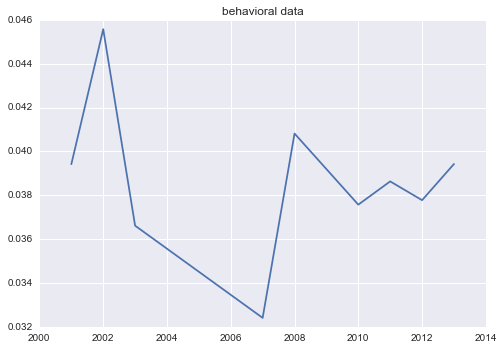

In [81]:
for i in at_list_words_change:
    if i[0] == 'CONTRIBUTION':
        plt.plot([j[0] for j in i[1]], [j[1] for j in i[1]])
        plt.title('behavioral data')

# Changes in phrase frequency

In [ ]:
#finds the top 20 phrases that increased/decreased the most- - title or abstract
list_pone = []
list_pdif = []
list_pdif2 = []
list_pdif_prev = []
for i in list_phrases_change:
    count = 0
    if len(i[1]) >= 1 and len(i[1]) <= 3:
        list_pone.append([ i[1][0][0], i[0], i[1][0][1]])
        list_pdif.append(0.0)
        list_pdif2.append(5.00)
    else: 
        for j in range(1, len(i[1])):
            if i[1][j][1]/i[1][j-1][1] > 1.00:
                count = count + 1
        list_pdif.append(count)
        list_pdif2.append(count)
        list_pdif_prev.append(count)
#print len(list_pone)

#print list_pone

list_ppos = []
list_ppos_min = []
ctt3 = 0

while ctt3 < 20:
    ind = list_pdif.index(max(list_pdif))
    ind2 = list_pdif2.index(min(list_pdif2))
    list_ppos.append(ind)
    list_ppos_min.append(ind2)
    list_pdif[ind] = 0.0
    list_pdif2[ind2] = 5.00
    ctt3 = ctt3 + 1

top20_pchanged = []

for i in list_ppos:
    words_old = list_phrases_change[i]
    temp_years = []
    temp_freqs = []
    for j in words_old[1]:
        temp_years.append(j[0])
        temp_freqs.append(j[1])
    top20_pchanged.append([words_old[0], temp_years, temp_freqs])

top20_pchanged_min = []
for i in list_ppos_min: 
    words_old = list_phrases_change[i]
    temp_years = []
    temp_freqs = []
    for j in words_old[1]:
        temp_years.append(j[0])
        temp_freqs.append(j[1])
    top20_pchanged_min.append([words_old[0], temp_years, temp_freqs])

#NOT doing norm(year)/norm(prev year) for quantification
top20_pnorm = []
for i in top20_pchanged:
    count = 0
    plist = []
    while count < len(i[1]):
        plist.append(i[2][count]) 
        count = count + 1
    top20_pnorm.append([i[0], i[1], plist])

#plot the 20 phrases
for i in top20_pnorm:
    plt.plot( i[1], i[2], label = i[0][0] + " " + i[0][1], color = [rand(), rand(), rand()])
    plt.legend(loc = "upper right", bbox_to_anchor = (1.4, 1))


In [ ]:
top20_pnorm_min = []
for i in top20_pchanged_min:
    count = 0
    plist = []
    while count < len(i[1]):
        plist.append(i[2][count]) 
        count = count + 1
    top20_pnorm_min.append([i[0], i[1], plist])

print top20_pnorm_min[0]
#plot the 20 phrases
for i in top20_pnorm_min:
    plt.plot(i[1], i[2], label = i[0][0] + " " + i[0][1], color = [rand(), rand(), rand()])
    plt.legend(loc = "upper right", bbox_to_anchor = (1.4, 1))

## Linear regression based on year and word/phrase frequency

In [ ]:
#make data frame of words using list_words_change
#only words that appear more than twice (or else throws error)
dfwords = pd.DataFrame()

col_words = []
col_years = []
col_freq = []
for i in at_list_words_change:
    if len(i[1]) > 2:
        for j in range(len(i[1])):
            col_words.append(i[0])
        for j in i[1]:
            col_years.append(j[0])
            col_freq.append(j[1])
dfwords["phrase"] = pd.Series(col_words)
dfwords["year"] = pd.Series(col_years)
dfwords["frequency"] = pd.Series(col_freq)
dfwords.head()

In [ ]:
dfwords[dfwords.phrase == "visual system"]


In [ ]:
phraselist = []
for i in dfwords["phrase"].tolist():
    if i not in phraselist:
        phraselist.append(i)
print phraselist[:10]
word_anova = []
word_lm_results = []
for phrase in set(phraselist):
    # Get data into R
    
    r.r_data = dfwords[dfwords.phrase == phrase]
    #print r('head(r_data)')

    # Define variables 
    dataVar = 'frequency'
    iv1 = 'year'

    # Run ANOVA using R syntax with string variable defined above
    r('anova <- lm('+dataVar+' ~ as.numeric('+iv1+'), data=r_data)')
    r('myModelSummary <- summary(anova)')
    #print r('summary(anova)')
    #print r('coef(anova)')
    word_lm_results.append([phrase, r.get('summary(anova)'), r.get('coef(anova)')])
    pval_int =  r.get('summary(anova)$coefficients[,4]')
    pval_test = r.get('summary(anova)$coefficients[,1]')
    if pval_int[1] < 0.05:
        word_anova.append([phrase, pval_int[1], pval_test[1]])
    


In [ ]:
print len(word_anova)
print len(at_list_words_change)

In [ ]:
#print word_anova[:10]

#get list of words [word, p, m] with steepest slope
anova_slope = []
for i in word_anova:
    anova_slope.append(i[2])
a = numpy.array(anova_slope)
anova_max_index = heapq.nlargest(len(a), range(len(a)), a.take)
#subset anova_slope
anova_slope_max = []
for i in anova_max_index:
    anova_slope_max.append(word_anova[i])

decreasing_tw = []
all_lm_data = []
for i in anova_slope_max:
    for j in at_list_words_change:
        if j[0] == i[0]:
            decreasing_tw.append(j)
            '''
            x_ax = []
            y_ax = []
            
            for k in j[1]:
                x_ax.append(k[0])
                y_ax.append(k[1])
            
            plt.plot( x_ax, y_ax, label = j[0], color = [rand(), rand(), rand()])
            plt.legend(loc = "upper right", bbox_to_anchor = (1.3, 1))
            '''
            
            break


In [ ]:

with open('WA2.csv', 'wb') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=' ',
                             quoting=csv.QUOTE_MINIMAL)
    for i in decreasing_tw:
        spamwriter.writerow(i)



In [ ]:
for i in plot_word_filter:
    if i[0] == "REPRESENTATIONS":
        plt.plot( i[1], i[2], label = i[0])
        plt.legend(loc = "upper right", bbox_to_anchor = (1.5, 1))

In [ ]:
#make a subset data frame of the 40 filtered words for the linear regression 

wfdf = pd.DataFrame()#pd.concat([dfwords[dfwords.phrase == word_filter[0][0]], dfwords[dfwords.phrase == word_filter[1][0]]])

for i in word_filter:
    wfdf = pd.concat([wfdf, dfwords[dfwords.phrase == i[0]]])


# Stable phrases
- small stdev
- small slopes

('visual', 'search') 0.0227223122923
('visual', 'information') 0.0244509045118
('visual', 'stimuli') 0.0270196463909
('low', 'spatial') 0.0280841458497
('better', 'performance') -0.0291800967993
('onset', 'asynchrony') -0.029743755361
('visual', 'processing') 0.03064355849
('primary', 'visual') -0.0315188455984
('detection', 'task') 0.0317632863031
('eye', 'movements') 0.0319178136582
('constant', 'stimuli') -0.0320373952099
('head-mounted', 'display') -0.0335310959962
('moving', 'stimulus') -0.0345394514636
('target', 'location') -0.034638522828
('parietal', 'cortex') 0.0377381684855
('pursuit', 'eye') -0.0384366295625
('visual', 'cortex') 0.0387016731134
('random', 'dots') -0.0387992742592
('three', 'conditions') -0.038829675422
('spatial', 'attention') 0.0392578990606


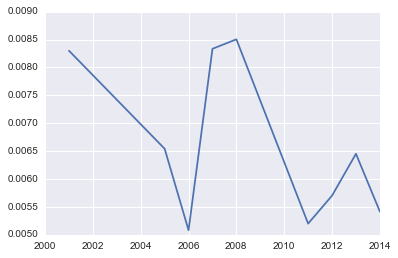

In [237]:
import ast
#look at steadiest phrases over time (slope/avg(vals) closest to 0)
pa = []
pa_freqs = []
f1 = open('PA.csv', 'r')
for line in f1:
    pa.append(line.strip().split(" "))
f2 = open('PA2.csv', 'r')
for line in f2:
    pa_freqs.append(line.split( "\""))
pa_freqs2 = []
for i in pa_freqs:
    pa_freqs2.append([ast.literal_eval(i[1]),ast.literal_eval(i[3])])

 

pa = [[ast.literal_eval(w + " " + x), float(y), float(z)] for w, x, y, z in pa]

pa_slopes = [z for x, y, z in pa]
for i in pa:
    for j in list_pc_edit:
        if j[0][0] + " " + j[0][1] == i[0]:
            avg = sum(j[2])/len(j[2])
            pa_slopes[pa.index(i)] = pa_slopes[pa.index(i)]/avg
            
a = np.array([abs(x) for x in pa_slopes])
phrase_st_small = heapq.nsmallest(len(pa), range(len(a)), a.take)

phrase_sts_list = []
ctta = 0
for i in phrase_st_small:
    for j in list_pc_edit:
        if j[0][0] + " " + j[0][1] == pa[i][0] and ctta < 20:
            if len(j[1]) > 8:
                phrase_sts_list.append(j + [pa_slopes[i]])
                ctta = ctta + 1
plt.plot(phrase_sts_list[4][1], phrase_sts_list[4][2], label = phrase_sts_list[1][0])

for w, x, y, z in phrase_sts_list:
    print w, z



('optic', 'flow')
0.0220660545535


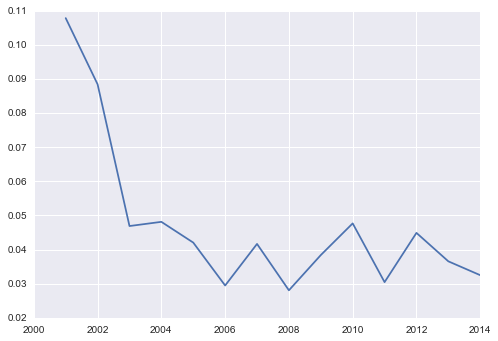

In [15]:
#looks at largest stdevs 
list_pc_edit = []
for x, y in list_phrases_change:
    list_pc_edit.append([x, [a for a, b in y], [b for a, b in y]])
    
phrases_st = [np.std(np.array(z)) for x, y, z in list_pc_edit] 

for i in phrases_st:
    if i == 0:
        phrases_st[phrases_st.index(i)] = -10.0

a = np.array(phrases_st)

phrase_st_large = heapq.nlargest(20, range(len(a)), a.take)

phrase_stl_list = []
for i in phrase_st_large:
    phrase_stl_list.append(list_pc_edit[i])

plt.plot(phrase_stl_list[3][1], phrase_stl_list[3][2], label = phrase_stl_list[3][0])

print phrase_stl_list[3][0]
print phrases_st[phrase_st_large[3]]

('frontal', 'eye') 0.000802433435836
('visual', 'display') 0.000887028584803
('subjective', 'equality') 0.00112487790522
('least', 'two') 0.00121563100847
('conjunction', 'search') 0.00125134288157
('better', 'performance') 0.00133369476912
('spatial', 'extent') 0.00134727144426
('very', 'similar') 0.0013702109697
('temporal', 'dynamics') 0.00138851220583
('search', 'array') 0.00140119846713
('head-mounted', 'display') 0.00142200488835
('dots', 'moved') 0.00145788068326
('spatial', 'position') 0.00146603587388
('what', 'extent') 0.00149351658928
('without', 'any') 0.00149630560017
('data', 'show') 0.00149975505772
('inferior', 'temporal') 0.00150719199817
('onset', 'asynchrony') 0.00151719568915
('reverse', 'correlation') 0.00152501864558
('some', 'trials') 0.00153251974304


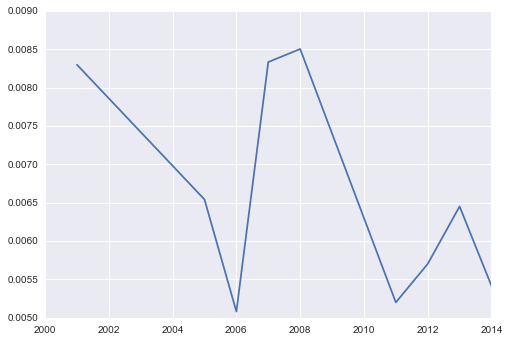

In [16]:
#find smallest stdevs in phrases

a = np.array([abs(x) for x in phrases_st])
phrase_st_small = heapq.nsmallest(len(a), range(len(a)), a.take)

phrase_sts_list = []
ctta = 0
for i in phrase_st_small:
    if len(list_pc_edit[i][1]) > 8 and ctta < 20:
        phrase_sts_list.append(list_pc_edit[i] + [a[i]])
        ctta = ctta + 1
plt.plot(phrase_sts_list[5][1], phrase_sts_list[5][2], label = phrase_sts_list[0][0])

for w, x, y, z in phrase_sts_list:
    print w, z


# Word correlations

In [ ]:
#find popular words across all abstracts


passage = df.abstract.str.cat(sep=' ') #this specifies to treat titles as 'str' and the concat all cells with a space separating
words = re.findall(r'\w+', passage)
cap_words = [word.upper() for word in words]
word_counts = Counter(cap_words)

sorted_wc = sorted(word_counts.items(), key=operator.itemgetter(1), reverse = True)


test_words = []

ctt = 0
ctt2 = 320
while ctt < 10:
    if str(sorted_wc[ctt2][0]).lower() not in wordlist:
        test_words.append(str(sorted_wc[ctt2][0]))
        ctt = ctt + 1
    ctt2 = ctt2 + 1
    
print test_words


In [58]:
#try for 10 words
corr_matrix = np.empty(shape = [len(test_words), len(test_words)])
for i in range(len(test_words)):
    if i% 100 == 0:
        print i
    temp_word = test_words[i].lower()
    for j in range(i + 1, len(test_words)):
        temp_word2 = test_words[j].lower()
        corr_matrix[i, j] = len(df[df.abstract.str.contains(temp_word) & df.abstract.str.contains(temp_word2)] )

0


In [62]:
print np.argmax(corr_matrix)
print test_words[0], test_words[8]

8
RESEARCH ABILITY


## % changes in word frequency for titles and abstracts 

In [ ]:
#finds the top 20 words that changed the most over the years 
list_one = []
list_dif = []
list_dif2 = []
#if a word only appears once, it's set to 0 (or else you get a lot of words that only appeared in one year)
for i in list_words_change:
    if len(i[1]) == 1:
        list_dif.append(0)
        list_dif2.append(0)
        list_one.append([i[1][0][0], i[0], i[1][0][1]])
    else:
        list_dif.append(i[1][len(i[1]) - 1][1] - i[1][0][1])
        list_dif2.append(i[1][len(i[1]) - 1][1] - i[1][0][1])
list_pos = []
list_pos_min = []
ctt3 = 0

while ctt3 < 20:
    ind = list_dif.index(max(list_dif))
    ind2 = list_dif2.index(min(list_dif2))
    list_pos.append(ind)
    list_pos_min.append(ind2)
    list_dif[ind] = 0.0
    list_dif2[ind2] = 5.0
    ctt3 = ctt3 + 1 

top20_changed = []
top20_changed_min = []
#reorgs top20 changed words in [['WORD', [years], [freqs]], etc]
for i in list_pos:
    words_old = list_words_change[i]
    temp_years = []
    temp_freqs = []
    for j in words_old[1]:
        temp_years.append(j[0])
        temp_freqs.append(j[1])
    top20_changed.append([words_old[0], temp_years, temp_freqs])

for i in list_pos_min:
    words_old = list_words_change[i]
    temp_years = []
    temp_freqs = []
    for j in words_old[1]:
        temp_years.append(j[0])
        temp_freqs.append(j[1])
    top20_changed_min.append([words_old[0], temp_years, temp_freqs]) 
#plot the 10 words
for i in top20_changed[1:]:
    
    plt.plot( i[1], i[2], label = i[0], color = [rand(), rand(), rand()])
    plt.legend(loc = "upper right", bbox_to_anchor = (1.4, 1))


In [ ]:
#plot changes over the year (increasing)
top20_delta = []
for i in top20_changed:
    temp_freqs_delta = []
    for j in range(len(i[1]) - 1):
        dif= i[2][j+1] - i[2][j]
        temp_freqs_delta.append(dif)
    top20_delta.append([i[0], i[1][:len(i[1]) - 1], temp_freqs_delta])

for i in top20_delta:
    plt.plot( i[1], i[2], label = i[0],color = [rand(), rand(), rand()] )
    plt.legend(loc = "upper right", bbox_to_anchor = (1.4, 1))
  

In [ ]:
#plot the 20 words that decreased in freq the most


for i in top20_changed_min:
    if i[0] != "MOTION":
        plt.plot( i[1], i[2], label = i[0], color = [rand(), rand(), rand()])
        plt.legend(loc = "upper right", bbox_to_anchor = (1.4, 1))

In [ ]:
#same thing, but for abstracts
#finds the top 20 words that changed the most over the years 

at_list_dif = []
at_list_dif2 = []
#if a word only appears once, it's set to 0 (or else you get a lot of words that only appeared in one year)
for i in at_list_words_change:
    if len(i[1]) == 1:
        at_list_dif.append(0)
        at_list_dif2.append(0)
    
    else:
        at_list_dif.append(i[1][len(i[1]) - 1][1] - i[1][0][1])
        at_list_dif2.append(i[1][len(i[1]) - 1][1] - i[1][0][1])
at_list_pos = []
at_list_pos_min = []

ctt3 = 0
print ct10
while ctt3 < 20:
    ind = at_list_dif.index(max(at_list_dif))
    ind2 = at_list_dif2.index(min(at_list_dif2))
    at_list_pos.append(ind)
    at_list_pos_min.append(ind2)
    at_list_dif[ind] = 0.0
    at_list_dif2[ind2] = 5.0
    ctt3 = ctt3 + 1 

at_top20_changed = []
at_top20_changed_min = []
#reorgs top20 changed words in [['WORD', [years], [freqs]], etc]
for i in at_list_pos:
    words_old = at_list_words_change[i]
    temp_years = []
    temp_freqs = []
    for j in words_old[1]:
        temp_years.append(j[0])
        temp_freqs.append(j[1])
    at_top20_changed.append([words_old[0], temp_years, temp_freqs])

for i in at_list_pos_min:
    words_old = at_list_words_change[i]
    temp_years = []
    temp_freqs = []
    for j in words_old[1]:
        temp_years.append(j[0])
        temp_freqs.append(j[1])
    at_top20_changed_min.append([words_old[0], temp_years, temp_freqs]) 
#plot the 20 words
for i in at_top20_changed:
    if i[0] != "VISUAL":
        plt.plot( i[1], i[2], label = i[0], color = [rand(), rand(), rand()])
        plt.legend(loc = "upper right", bbox_to_anchor = (1.5, 1))


In [ ]:
print at_list_words_change[0][1][len(at_list_words_change[0][1]) - 1][1]

at_2014 = df[df.year == "2014"].abstract.str.cat(sep=" ")